In [8]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [9]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [10]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [11]:
def factor(df, window=20):
    """
    改进：引入主动买卖量(taker_buy_volume)计算多空力量加权重心
    金融意义：更精准捕捉大单资金流向，识别机构行为
    """
    df = df.copy()
    # 计算主动卖出量
    df['taker_sell_volume'] = df['volume'] - df['taker_buy_volume']
    
    daily_results = []
    for date, group in df.groupby(pd.Grouper(freq='D')):
        if len(group) < 4:
            continue
            
        time_idx = np.arange(len(group))
        # 计算多空力量比率
        group['buy_power'] = group['taker_buy_volume'] / group['volume']
        group['sell_power'] = group['taker_sell_volume'] / group['volume']
        
        # 上涨K线：使用买方力量加权
        up_mask = group['close'] > group['open']
        if up_mask.any():
            up_weights = group.loc[up_mask, 'buy_power'] * group.loc[up_mask, 'volume']
            G_u = np.sum(time_idx[up_mask] * up_weights) / up_weights.sum()
        else:
            G_u = np.nan
            
        # 下跌K线：使用卖方力量加权
        down_mask = group['close'] < group['open']
        if down_mask.any():
            down_weights = group.loc[down_mask, 'sell_power'] * group.loc[down_mask, 'volume']
            G_d = np.sum(time_idx[down_mask] * down_weights) / down_weights.sum()
        else:
            G_d = np.nan
            
        daily_results.append({
            'date': date,
            'G_u': G_u,
            'G_d': G_d
        })
    
    daily_df = pd.DataFrame(daily_results).set_index('date')
    
    # 动态波动率调整回归
    residuals = []
    for i in range(window, len(daily_df)):
        train_data = daily_df.iloc[i-window:i]
        if len(train_data.dropna()) < 10:
            residuals.append(np.nan)
            continue
            
        # 计算波动率作为回归权重
        volatility = train_data[['G_u', 'G_d']].diff().abs().mean(axis=1).fillna(0.01)
        
        X = train_data[['G_u']].values
        y = train_data['G_d'].values
        model = LinearRegression()
        model.fit(X, y, sample_weight=volatility)  # 高波动期给予更高权重
        
        current = daily_df.iloc[i]
        if pd.isna(current['G_u']) or pd.isna(current['G_d']):
            residuals.append(np.nan)
        else:
            pred_G_d = model.predict([[current['G_u']]])[0]
            residuals.append(current['G_d'] - pred_G_d)
    
    daily_df = daily_df.iloc[window:]
    daily_df['residual'] = residuals
    
    # 自适应移动平均
    volatility = daily_df['residual'].diff().abs().rolling(5).std()
    daily_df['factor'] = daily_df['residual'].rolling(
        window).mean() / np.maximum(volatility, 0.01)
    
    df['factor_value'] = np.nan
    for date, row in daily_df.iterrows():
        mask = (df.index.date == date.date())
        df.loc[mask, 'factor_value'] = row['factor']
    
    return -df['factor_value']

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.011096
   Rank_IC (Spearman): 0.009787
📊 信息比率:
   IR: 0.163540
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 127291
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


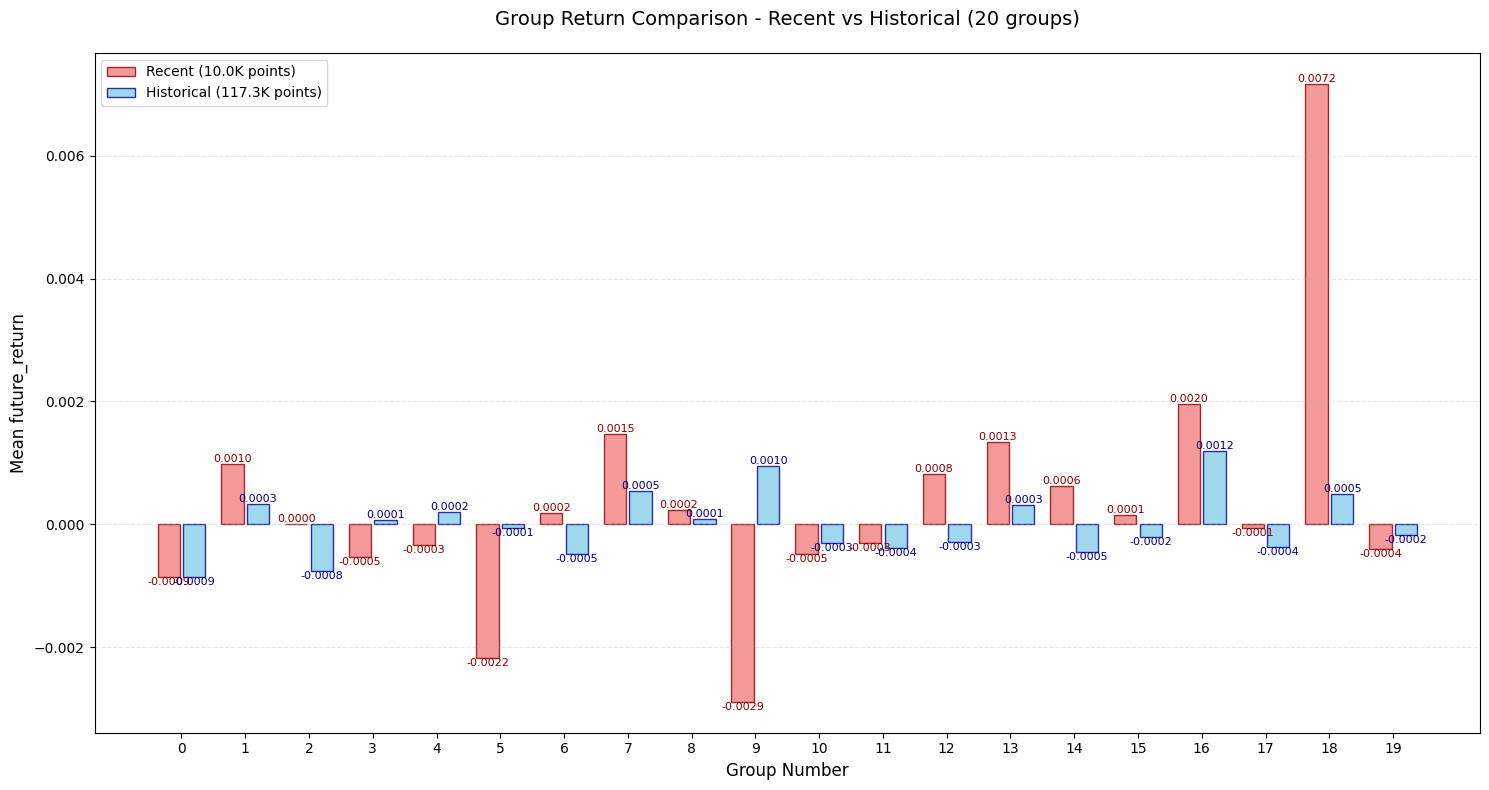

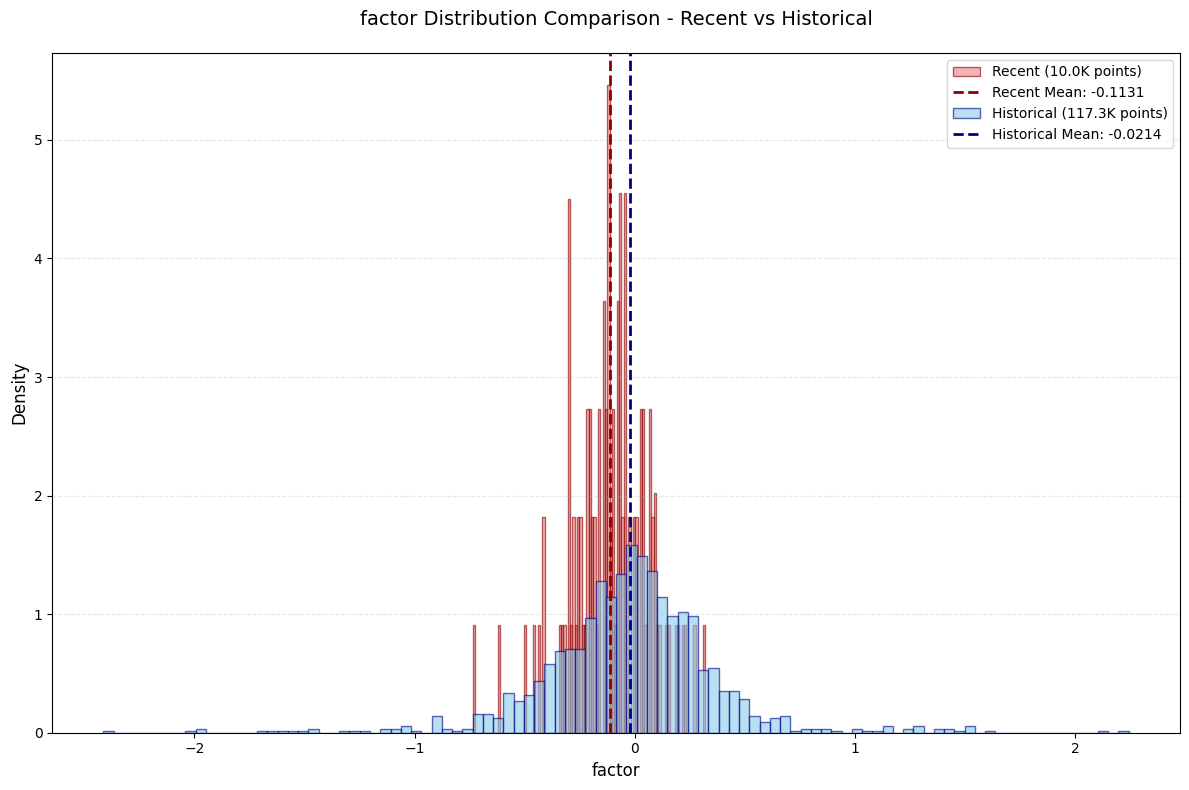

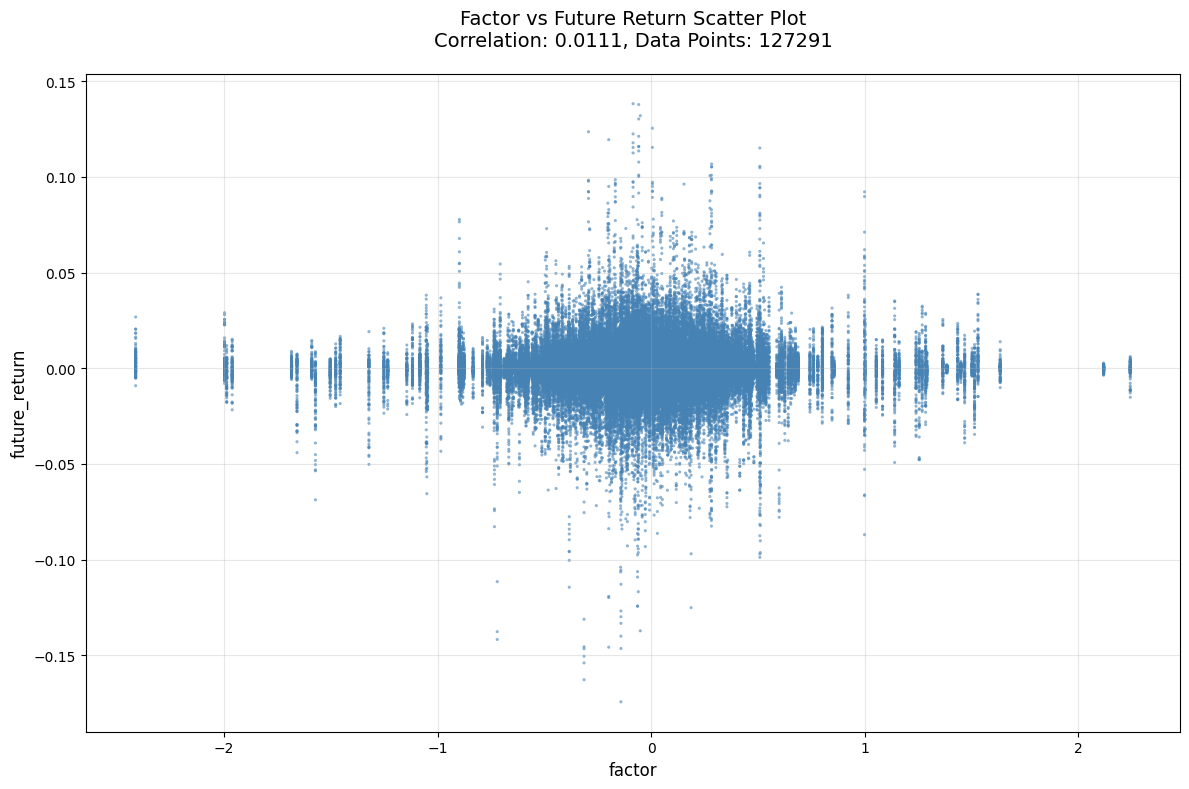

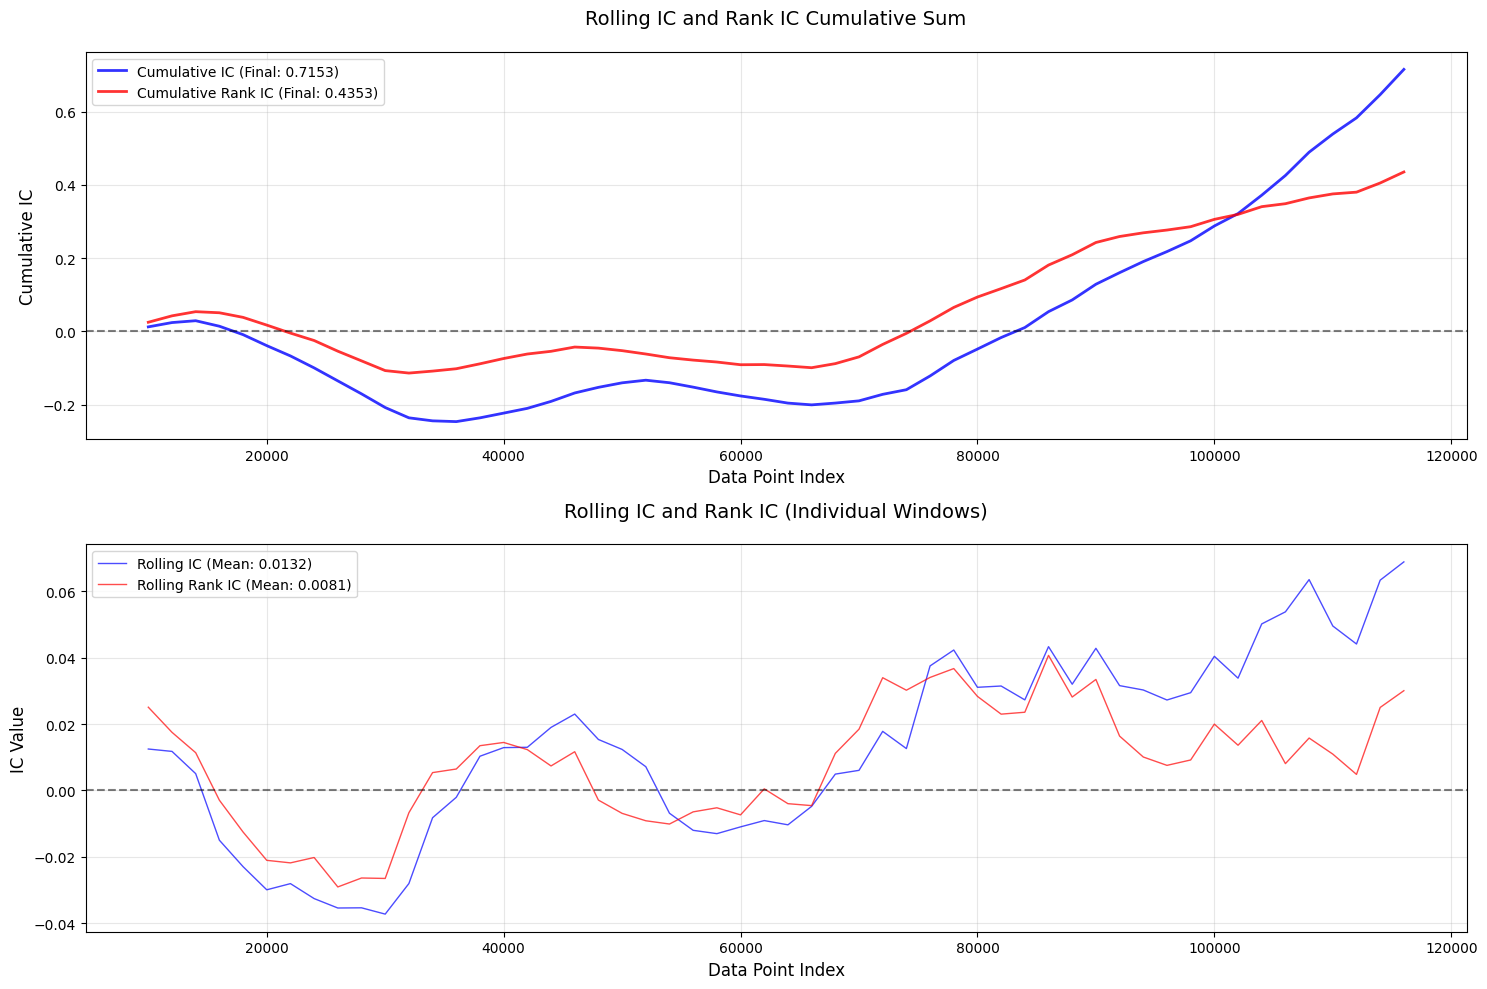

✅ 已显示 4 个图片
----------------------------------------


In [12]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [13]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[0.030809464280261364,
 0.037758830997696405,
 -0.000567099976389165,
 0.022667045020988746,
 -0.0027988303315771884,
 -0.023159368373492133,
 0.041998470653898896,
 -0.0017477799080304107,
 -0.027034757737581037,
 -0.03479449675300663]

In [14]:
print(result)

{'correlation_analysis': {'IC': 0.011096219835271889, 'Rank_IC': 0.009786535215441842}, 'information_ratio': {'IR': 0.16354011619460357, 'group_correlations': [0.030809464280261364, 0.037758830997696405, -0.000567099976389165, 0.022667045020988746, -0.0027988303315771884, -0.023159368373492133, 0.041998470653898896, -0.0017477799080304107, -0.027034757737581037, -0.03479449675300663], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -2.4131  -0.5878   -0.9538      -0.0009      0.0104   6432
1      -0.5856  -0.4211   -0.4985       0.0000      0.0103   6336
2      -0.4205  -0.3341   -0.3780      -0.0005      0.0104   6336
3      -0.3341  -0.2718   -0.3038       0.0003      0.0119   6427
4      -0.2715  -0.2079   -0.2388       0.0000      0.0107   6336
5      -0.2072  -0.1675   -0.1870      -0.0001      0.0138   6336
6      -0.1650  -0.1299   -0.1469